<a href="https://colab.research.google.com/github/absbin/AGCWD/blob/master/Deep_Features2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
from tqdm import tqdm

import os
import sys
import cv2
import glob
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn import svm
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import zipfile
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

use_gpu = torch.cuda.is_available()

In [0]:
#cd "/content/drive/My Drive/kargah DL with python code/Week07/Persian_Image_Captioning"



In [0]:
#os.chdir('/content/drive/My Drive/kargah DL with python code/Week07/Persian_Image_Captioning')


In [2]:
!ls

sample_data


In [0]:
#from utils import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!git clone https://github.com/absbin/umap.git
import umap

Cloning into 'umap'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 2739 (delta 7), reused 19 (delta 7), pack-reused 2719
Receiving objects: 100% (2739/2739), 13.44 MiB | 5.03 MiB/s, done.
Resolving deltas: 100% (1809/1809), done.


In [6]:
!ls "/content/drive/My Drive"

 classifierCATvsDOG.pt		    'kargah DL with python code'
 code				     laparoscopy
'Colab Notebooks'		     resnet152_weights_tf.h5
'Copy of Untitled1.ipynb'	     sesssion1_DL_cnn_pytorch.ipynb
 data				     Untitled1.ipynb
 DeepFeatures			     week1snrDL
 Deep_Features_classifier_cv.ipynb


In [0]:
local_zip = '/content/drive/My Drive/data/totoroframes.zip'



In [0]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/data')
zip_ref.close()



In [0]:
#base_dir = '/content/drive/My Drive/data/WCE_dataset_3'
trn_dir = '/data/totoroframes'


In [0]:
classes=os.listdir(trn_dir)

In [11]:
classes[0]

'frame208.jpg'

In [0]:
import re
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [0]:
classes=sorted_aphanumeric(classes)

In [0]:
#classes

In [15]:
classes[0]

'frame1.jpg'

In [16]:
trn_frames = glob.glob(f'{trn_dir}/*.jpg')

len(trn_frames)


895

In [17]:
trn_frames[0]

'/data/totoroframes/frame208.jpg'

In [0]:
from natsort import natsorted, ns
trn_frames=natsorted(trn_frames, key=lambda y: y.lower())

In [0]:
#trn_frames

In [20]:
!ls

drive  sample_data  umap


In [21]:
print( os.getcwd() )

/content


**Model**

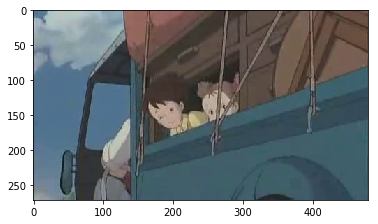

In [22]:
img=plt.imread(trn_frames[155])
plt.imshow(img)

**`Super pixel segmentation`**

---



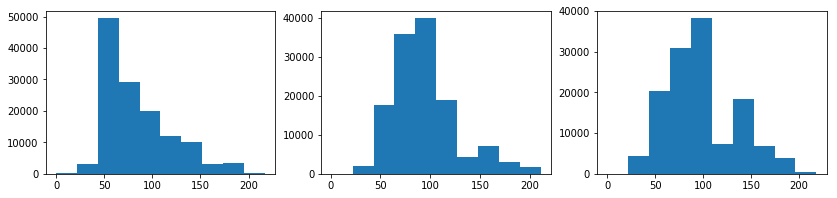

In [23]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
bin_counts,_,_  = plt.hist(img[:,:,0].ravel(), bins=10)
plt.subplot(1,3,2)
bin_counts,_,_  = plt.hist(img[:,:,1].ravel(), bins=10)
plt.subplot(1,3,3)
bin_counts,_,_  = plt.hist(img[:,:,2].ravel(), bins=10)


In [24]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
def feature_extractor(X):

    frames=X
    #model_vgg16 = VGG16(weights='imagenet', include_top=False)
    model_vgg16 = ResNet50(weights='imagenet', include_top=False)
    vgg16_feature_list = []
    vgg16_feature_list_np=[]
    labels_true=[]
    hsv=[]
    img_address=[]
    for i, fname in enumerate(frames ):
        img = image.load_img(fname, target_size=(224, 224))          

        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        vgg16_feature = model_vgg16.predict(img_data)
        vgg16_feature_np = np.array(vgg16_feature)
        vgg16_feature_list.append(vgg16_feature_np.flatten())
        img_address.append(fname)
        print(i,'   ', fname)
    vgg16_feature_list_np = np.array(vgg16_feature_list)
    return vgg16_feature_list_np ,img_address

Using TensorFlow backend.


In [25]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision.transforms as transforms
import torchvision.models as models
from torch.autograd import Variable

In [0]:
resnet50 = ResNet50(weights='imagenet', include_top=True)

Instructions for updating:
Colocations handled automatically by placer.
 10969088/102853048 [==>...........................] - ETA: 3:13

In [0]:

def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)


In [0]:

def load_image(image_path, transform=None):
    "Load an image and perform given transformations."
    image = Image.open(image_path)    
    if transform is not None:
       image = transform(image).unsqueeze(0)
    return image
  
def load_cnn_model(model_name, pretrained=True):
    "Load and return a convolutional neural network."
    assert model_name in ['ResNet50','resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
    return models.__dict__[model_name](pretrained)


class EncoderCNN(nn.Module):
    def __init__(self, model_name):
        super(EncoderCNN, self).__init__()
        
        # load cnn and remove last layer
        cnn = load_cnn_model(model_name)
        modules = list(cnn.children())[:-1]  # remove last layer
        
        self.cnn = nn.Sequential(*modules)

    def encoder(self, x):
        x = self.cnn(x)  # extract features from input image
        print(x.size())
        x = Variable(x.data)
        print(x.size())
        return x

In [0]:
cnn_name = 'resnet152'


In [0]:

model = EncoderCNN(cnn_name)
if use_gpu:
    model = model.cuda()

In [0]:
image = load_image(img_filenames[0], val_transform)  
image_tensor = to_var(image, volatile=False)
features= model.encoder(image_tensor)

In [0]:
features=torch.tensor([])
img_filenames =trn_frames 
from PIL import Image
image_size = (224,224)

val_transform = transforms.Compose([
    transforms.Resize(image_size),    
    transforms.ToTensor()
])


for img_filename in img_filenames:
    print(img_filename)
    # prepare test image
    image = load_image(img_filename, val_transform)
    print(image[0].size())
    plt.imshow(  image[0].permute(1, 2, 0)  )
    image_tensor = to_var(image, volatile=False)
    # Generate features from image
    feature = model.encoder(image_tensor)   
    print(features.size)
    features=torch.cat([features,feature],dim=0)
    print(features.size)
    #feature=torch.squeeze(feature,3)
 
    #cnn_feature.append(feature) 
   

In [0]:
print(np.shape(features))

In [0]:
trn_frames

In [0]:
feature.size

In [0]:
image_tensor.Session().run((image_tensor))

In [0]:
x_data,address=feature_extractor(trn_frames)

In [0]:
x_data.shape


In [0]:
!ls

In [0]:
!ls "/content/drive/My Drive"

In [0]:
cd "/content/drive/My Drive/data"

In [0]:
!ls

In [0]:
#import numpy as np
#np.savetxt('data.csv', (x_data), delimiter=',')

In [0]:
os.chdir('/content/drive/My Drive/data')

In [0]:
#!mkdir demo
#%cd demo
#!pwd

In [0]:
#%cd 

In [0]:
!pwd2

In [0]:
!ls

In [0]:
x_data.shape

# **Visual Comparison UMAP T-SNE PCA**

In [0]:
from sklearn.datasets import load_digits

digits = load_digits()

embedding = umap.UMAP().fit_transform(digits.data)
digits.data.shape
embedding.shape
digits.target
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.scatter(embedding[:, 0], embedding[:, 1],c=digits.target,   cmap='Spectral', s=5,alpha=.5)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the digits', fontsize=14);

tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=2000)
x_data_tsne=tsne.fit_transform(digits.data)
plt.subplot(1,3,2)
plt.scatter(x_data_tsne[:, 0], x_data_tsne[:, 1],c=digits.target,   cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('T-SNE projection of the digits', fontsize=14);


plt.subplot(1,3,3)
pca=PCA(n_components=2)
x_data_pca = pca.fit(digits.data)  
x_data_pca= x_data_pca.transform(digits.data)
plt.scatter(x_data_pca[:, 0], x_data_pca[:, 1],c=digits.target,   cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('PCA projection of the digits', fontsize=14);

**Performing PCA for dimentionality reduction**


> 

---




> 



In [0]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
# pca = PCA(.05)  
x_data_pca = pca.fit_transform(x_data)  
#x_data_pca= x_data_pca.transform(x_data)
print(x_data_pca.shape)
print(x_data.shape)

# umap

In [0]:
!git clone https://github.com/absbin/umap.git

In [0]:
import umap


In [0]:
embedding = umap.UMAP(n_components=2).fit_transform(x_data)
x_data_umap=embedding
embedding.shape


In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=300)
x_data_tsne=tsne.fit_transform(x_data)
x_data_tsne.shape

# **Totoro 2 component UMAP T-SNE PCA**

In [0]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.scatter(x_data_pca[:, 0], x_data_pca[:, 1],  cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('PCA projection of the Totoro', fontsize=14);

plt.subplot(1,3,2)
plt.scatter(x_data_tsne[:, 0], x_data_tsne[:, 1],  cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('TSNE projection of the Totoro ', fontsize=14);

plt.subplot(1,3,3)
plt.scatter(embedding[:, 0], embedding[:, 1],  cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Totoro', fontsize=14);

In [0]:
pca = PCA(.05)  
pca=PCA(n_components=20)
x_data_pca = pca.fit_transform(x_data)  
print(x_data_pca.shape)



In [0]:

tsne = TSNE(perplexity=30,n_components=5,init='pca',n_iter=300)
x_data_tsne=tsne.fit_transform(x_data)
print(x_data_tsne.shape)


In [0]:


embedding = umap.UMAP(n_components=20).fit_transform(x_data)
x_data_umap=embedding
print(x_data_umap.shape)


In [0]:
cd "/content/drive/My Drive/data"

In [0]:
# construct dataframe, index [0] to make 2d
df = pd.DataFrame(x_data_pca)
# save to Excel, exclude index and headers
df.to_excel('x_data_pca.xlsx', index=False, header=False)

df = pd.DataFrame(x_data_tsne)
df.to_excel('x_data_tsne.xlsx', index=False, header=False)

df = pd.DataFrame(x_data_umap)
df.to_excel('x_data_umap.xlsx', index=False, header=False)

In [0]:
import csv
f = open('totoro.csv', 'w')
with f:
    writer = csv.writer(f)
    
    for row in x_data:
        writer.writerow(row)

In [0]:
generate_excel(x_data=x_data_pca, excel_loc='A1' ,sheet_='Sheet1)
               